# Analytics of ML Features Usage in IDEs

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data loading

In [4]:
data = pd.read_csv('da_internship_task_dataset.csv')
data.head()

,uuid,day_id,license,model,feature,requests_cnt,spent_amount
0,user_920,2025-05-01,Premium,Model_A,Feature_1,44.0,16.38
1,user_717,2025-03-04,Premium,Model_B,Feature_2,72.0,27.92
2,user_610,2025-05-08,Premium,Model_A,Feature_2,27.0,9.87
3,user_94,2025-03-11,Basic,Model_D,Feature_1,76.0,14.67
4,user_920,2025-05-14,Premium,Model_E,Feature_3,47.0,9.88


## Exploratory data analysis

In [5]:
print(data.describe())
print(data.info())

        requests_cnt   spent_amount
count  122746.000000  122746.000000
mean       51.260742      12.227798
std       167.977380      37.588494
min         1.000000       0.270000
25%        18.000000       5.140000
50%        32.000000       8.020000
75%        54.000000      13.060000
max     12900.000000    2599.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122746 entries, 0 to 122745
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   uuid          122746 non-null  object 
 1   day_id        122746 non-null  object 
 2   license       122746 non-null  object 
 3   model         122746 non-null  object 
 4   feature       122746 non-null  object 
 5   requests_cnt  122746 non-null  float64
 6   spent_amount  122746 non-null  float64
dtypes: float64(2), object(5)
memory usage: 6.6+ MB
None


The dataset has 122746 rows and 7 columns. Data are complete, there is no null values. For both columns *requests_cnt* and *spent_amount* max values are extremely high (outliers) comparing to median and mean, so standard deviation is also high.

The data shows information about activity of 1866 users. Data was collected over 3 months period.

In [6]:
data['uuid'].drop_duplicates().count()

np.int64(1866)

We plot distributions of columns *requests_cnt* and *spent_amount*. Due to they have some extremely high values we plot histograms for instances which has values < 99th percentile (for full range we can't see anything on plot).

Also for further analysis we will plot dependencies only for instances with values < 99th percentile, so we create dataframe for these instances.

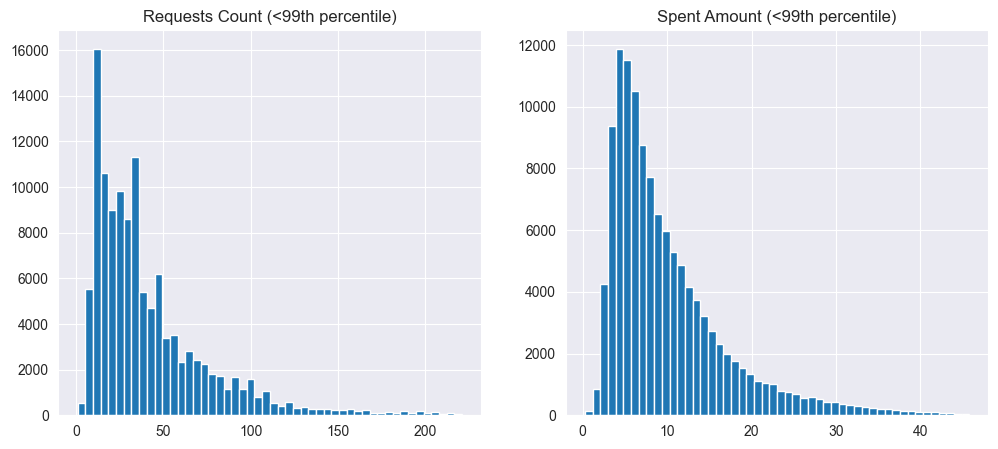

In [7]:
p99_requests = data['requests_cnt'].quantile(0.99)
p99_spent = data['spent_amount'].quantile(0.99)

# dataframe without outliers
data_p99 = data[(data['requests_cnt'] < p99_requests) & (data['spent_amount'] < p99_spent)]


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(data_p99['requests_cnt'], bins=50)
axes[0].set_title("Requests Count (<99th percentile)")

axes[1].hist(data_p99['spent_amount'], bins=50)
axes[1].set_title("Spent Amount (<99th percentile)")

plt.show()

For both columns distribution is skewed and has the same shape. It suggests that most of the users use LLM tools moderately, rather less than more. Plots explain relatively low values of medians and high standard deviation. We expect that between these two columns correlation is very high.

              requests_cnt  spent_amount
requests_cnt      1.000000      0.944177
spent_amount      0.944177      1.000000


<Axes: xlabel='requests_cnt', ylabel='spent_amount'>

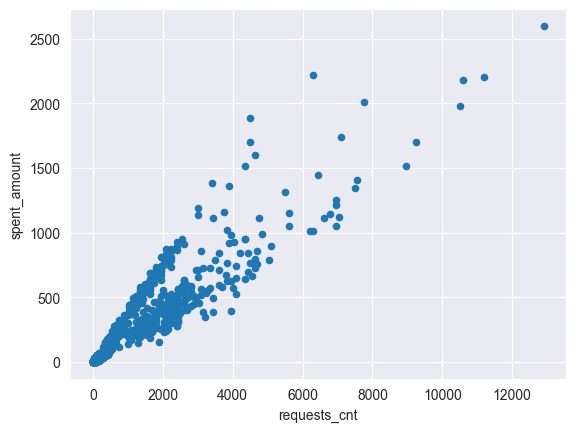

In [8]:
corr = data[['requests_cnt', 'spent_amount']].corr()
print(corr)

data.plot.scatter(x='requests_cnt', y='spent_amount')

The correlation between *requests_cnt* and *spent_amount* is close to one. It means that users, who send more requests spend also more credits.

Now we take a look to columns *license*, *model*, and *feature*.

### License analysis

In [9]:
data['license'].value_counts()

license
Basic         39233
Standard      37368
Enterprise    23516
Premium       22629
Name: count, dtype: int64

In [10]:
data.groupby('license')[['requests_cnt', 'spent_amount']].median()

,requests_cnt,spent_amount
license,,
Basic,20.0,4.93
Enterprise,63.0,15.27
Premium,49.0,11.87
Standard,28.0,6.86


In [11]:
data.groupby('license')[['requests_cnt', 'spent_amount']].std()

,requests_cnt,spent_amount
license,,
Basic,72.676932,15.066691
Enterprise,126.284404,43.376149
Premium,287.571104,60.108829
Standard,159.332995,30.539533


<Axes: xlabel='license', ylabel='requests_cnt'>

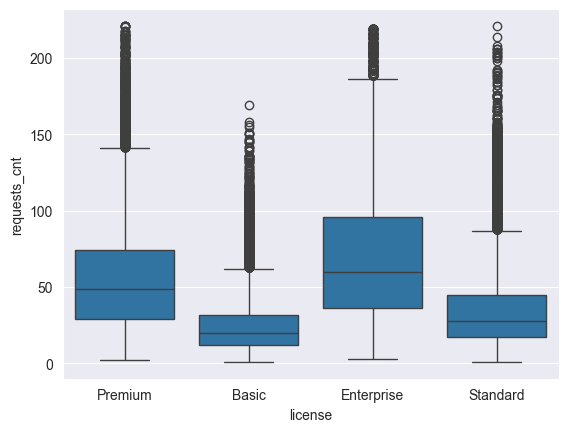

In [29]:
sns.boxplot(data=data_p99, x='license', y='requests_cnt')

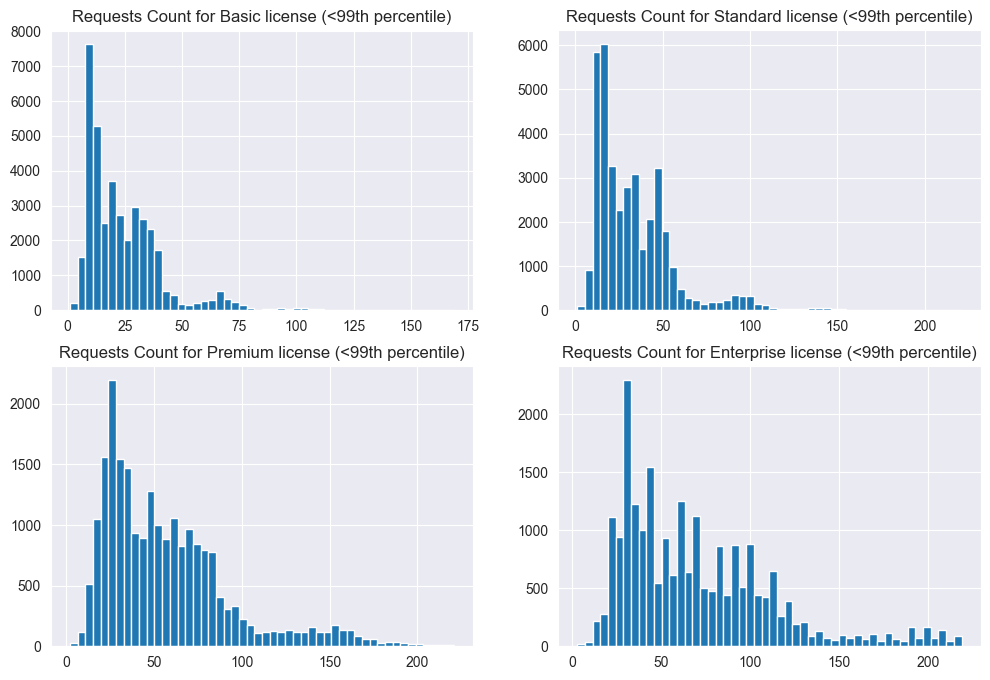

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0,0].hist(data_p99[data_p99['license']=='Basic']['requests_cnt'], bins=50)
axes[0,0].set_title("Requests Count for Basic license (<99th percentile)")

axes[0,1].hist(data_p99[data_p99['license']=='Standard']['requests_cnt'], bins=50)
axes[0,1].set_title("Requests Count for Standard license (<99th percentile)")

axes[1,0].hist(data_p99[data_p99['license']=='Premium']['requests_cnt'], bins=50)
axes[1,0].set_title("Requests Count for Premium license (<99th percentile)")

axes[1,1].hist(data_p99[data_p99['license']=='Enterprise']['requests_cnt'], bins=50)
axes[1,1].set_title("Requests Count for Enterprise license (<99th percentile)")

plt.show()

There are 4 types of *license*. *Basic* and *Standard* are the most popular types, however users with license *Premium* or *Enterprise* use definitely more LLM tools. It suggests that users, who are professionals or developers and who code a lot using LLM, prefer *Premium* or *Enterprise* license. The majority of users are 'common', they don't need to use so much LLM, so for them *Basic* and *Standard* license are completely enough. Boxplot shows clearly two groups: *Basic*+*Standard* and *Premium*+*Enterprise*

We also see that for each license type standard deviation is very high comparing to median values and there is still a lot of outliers even after filtering some of them, so we shouldn't generalize these results. Additionally, we plotted distributions for each type, which also show differences between these two groups.

### Models analysis

In [13]:
data['model'].value_counts()

model
Model_A    38042
Model_C    24433
Model_D    24423
Model_B    23110
Model_E    12738
Name: count, dtype: int64

In [14]:
data.groupby('model')[['requests_cnt', 'spent_amount']].median()

,requests_cnt,spent_amount
model,,
Model_A,17.0,6.360
Model_B,21.0,7.600
Model_C,48.0,8.990
Model_D,50.0,9.930
Model_E,45.0,8.485


In [15]:
data.groupby('model')[['requests_cnt', 'spent_amount']].std()

,requests_cnt,spent_amount
model,,
Model_A,69.990911,25.809304
Model_B,115.046935,42.330514
Model_C,282.339202,54.463744
Model_D,192.551137,36.012331
Model_E,61.527711,12.175694


<Axes: xlabel='model', ylabel='requests_cnt'>

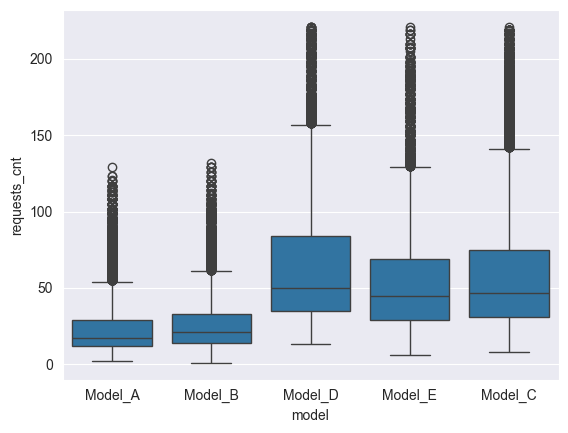

In [28]:
sns.boxplot(data=data_p99, x='model', y='requests_cnt')

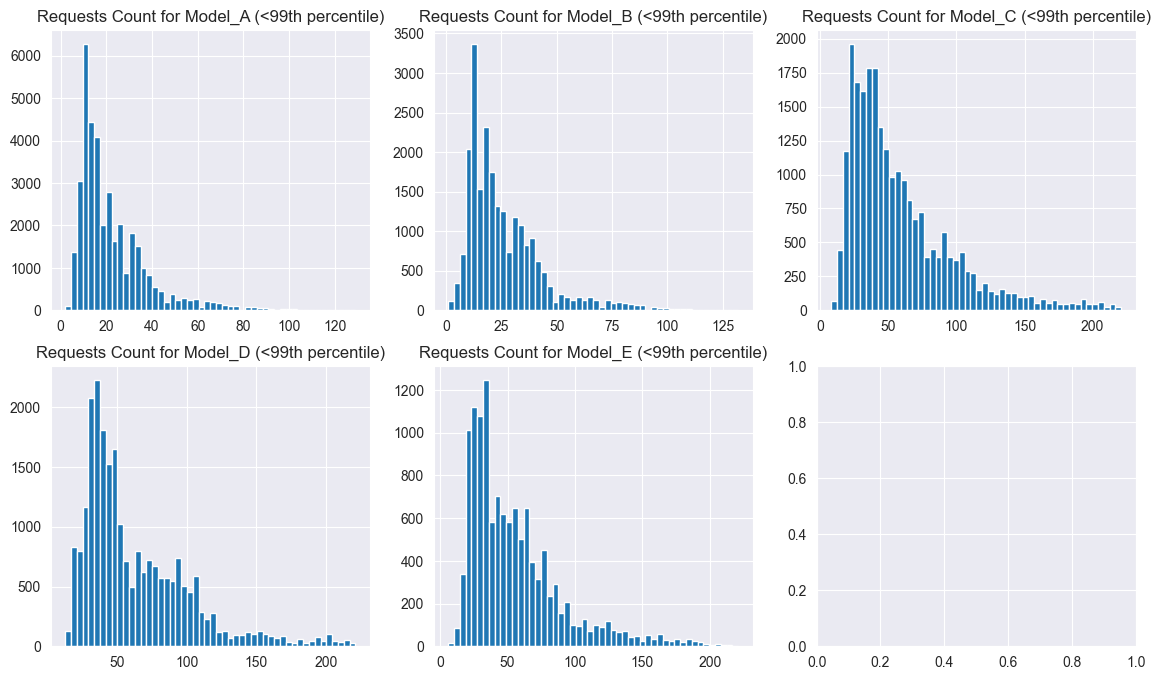

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

axes[0,0].hist(data_p99[data_p99['model']=='Model_A']['requests_cnt'], bins=50)
axes[0,0].set_title("Requests Count for Model_A (<99th percentile)")

axes[0,1].hist(data_p99[data_p99['model']=='Model_B']['requests_cnt'], bins=50)
axes[0,1].set_title("Requests Count for Model_B (<99th percentile)")

axes[0,2].hist(data_p99[data_p99['model']=='Model_C']['requests_cnt'], bins=50)
axes[0,2].set_title("Requests Count for Model_C (<99th percentile)")

axes[1,0].hist(data_p99[data_p99['model']=='Model_D']['requests_cnt'], bins=50)
axes[1,0].set_title("Requests Count for Model_D (<99th percentile)")

axes[1,1].hist(data_p99[data_p99['model']=='Model_E']['requests_cnt'], bins=50)
axes[1,1].set_title("Requests Count for Model_E (<99th percentile)")

plt.show()

The most popular is *Model_A*, and *Model_E* is definitely the least popular. There is no significant differences in popularity between models *B*, *C*, and *D*. When we analyse how many requests users send to particular types, we can see that users use more models *C*, *D*, and *E*. Boxplot shows that for *A* and *B* we do not have so high values as for other models. On histograms, we see that *A* and *B* are used less, while the rest is used more. Probably models *A* and *B* are used by users with *Basic* and *Standard* license, and *C*, *D*, and *E* are used by users with *Premium* or *Enterprise* license.

### Features analysis

In [18]:
data['feature'].value_counts()

feature
Feature_1    45399
Feature_2    36449
Feature_3    26283
Feature_5     7372
Feature_4     7243
Name: count, dtype: int64

In [19]:
data.groupby('feature')[['requests_cnt', 'spent_amount']].median()

,requests_cnt,spent_amount
feature,,
Feature_1,35.0,8.76
Feature_2,31.0,7.82
Feature_3,29.0,7.46
Feature_4,37.0,8.26
Feature_5,26.0,6.60


In [20]:
data.groupby('feature')[['requests_cnt', 'spent_amount']].std()

,requests_cnt,spent_amount
feature,,
Feature_1,194.314809,40.040272
Feature_2,153.524718,38.830995
Feature_3,129.585523,32.302560
Feature_4,210.805842,43.369655
Feature_5,128.276726,24.636325


<Axes: xlabel='feature', ylabel='requests_cnt'>

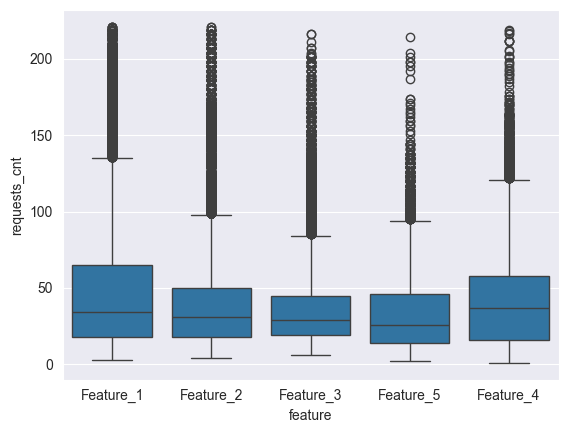

In [24]:
sns.boxplot(data=data_p99, x='feature', y='requests_cnt')

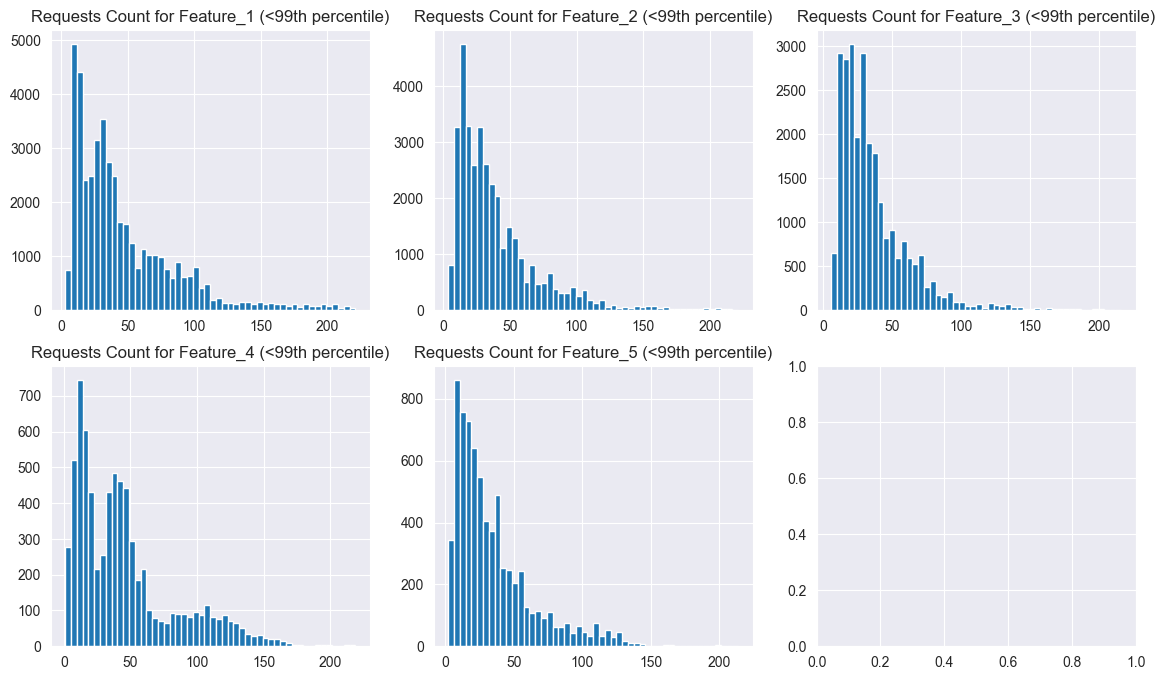

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

axes[0,0].hist(data_p99[data_p99['feature']=='Feature_1']['requests_cnt'], bins=50)
axes[0,0].set_title("Requests Count for Feature_1 (<99th percentile)")

axes[0,1].hist(data_p99[data_p99['feature']=='Feature_2']['requests_cnt'], bins=50)
axes[0,1].set_title("Requests Count for Feature_2 (<99th percentile)")

axes[0,2].hist(data_p99[data_p99['feature']=='Feature_3']['requests_cnt'], bins=50)
axes[0,2].set_title("Requests Count for Feature_3 (<99th percentile)")

axes[1,0].hist(data_p99[data_p99['feature']=='Feature_4']['requests_cnt'], bins=50)
axes[1,0].set_title("Requests Count for Feature_4 (<99th percentile)")

axes[1,1].hist(data_p99[data_p99['feature']=='Feature_5']['requests_cnt'], bins=50)
axes[1,1].set_title("Requests Count for Feature_5 (<99th percentile)")

plt.show()

The most popular features are Feature_1, Feature_2, and Feature_3. Feature_4 and Feature_5 are far less popular. There is no very big differences between medians of requests for each model, but we observe the highest median for *Feature_4*, and the lower for *Feature_5*. Also for this column standard deviation is extremely high. Boxplot visualize small differences in values of medians. On histograms, we only see the differences in requests count.

### Features vs. Models and Licenses

<Axes: xlabel='feature', ylabel='model'>

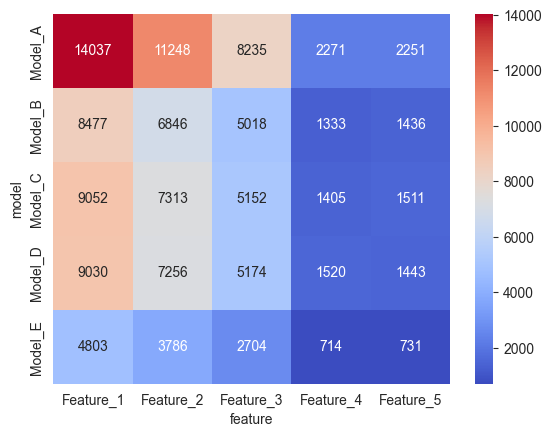

In [31]:
cross_model_feature = pd.crosstab(data['model'], data['feature'])
sns.heatmap(cross_model_feature, annot=True, fmt='d', cmap='coolwarm')

<Axes: xlabel='feature', ylabel='license'>

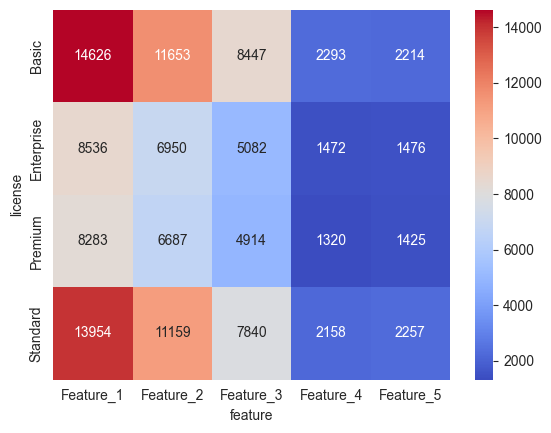

In [32]:
cross_license_feature = pd.crosstab(data['license'], data['feature'])
sns.heatmap(cross_license_feature, annot=True, fmt='d', cmap='coolwarm')

These heatmaps show what we have already observed. Because features *1* and *2*, licenses *Basic* and *Standard*, and *Model_A* are the most popular, they dominate heatmaps. It is rather just statistics than any connections between using certain features with certain models or licenses.

### Analysis of trends over time

Firstly, we convert *day_id* to datetime format.

In [35]:
data['day_id'] = pd.to_datetime(data['day_id'])
data.head()

,uuid,day_id,license,model,feature,requests_cnt,spent_amount
0,user_920,2025-05-01,Premium,Model_A,Feature_1,44.0,16.38
1,user_717,2025-03-04,Premium,Model_B,Feature_2,72.0,27.92
2,user_610,2025-05-08,Premium,Model_A,Feature_2,27.0,9.87
3,user_94,2025-03-11,Basic,Model_D,Feature_1,76.0,14.67
4,user_920,2025-05-14,Premium,Model_E,Feature_3,47.0,9.88


<Axes: xlabel='day_id'>

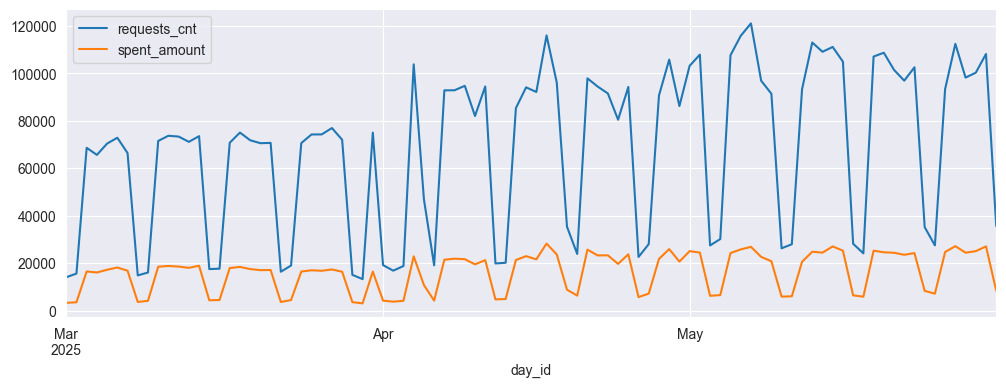

In [38]:
daily = data.groupby('day_id')[['requests_cnt', 'spent_amount']].sum()
daily.plot(figsize=(12,4))

The daily perspective shows some trends. For first month activity was definitely lower than for next two months. Moreover, we can see regular breakdowns - probably it is related to weekends, they seem to occur every 7 days. It could be due to professional developers, who use LLM tools at most do not work during weekends. There is one additional breakdown in April. Maybe it is due to some event such as Easter.

<Axes: xlabel='day_id'>

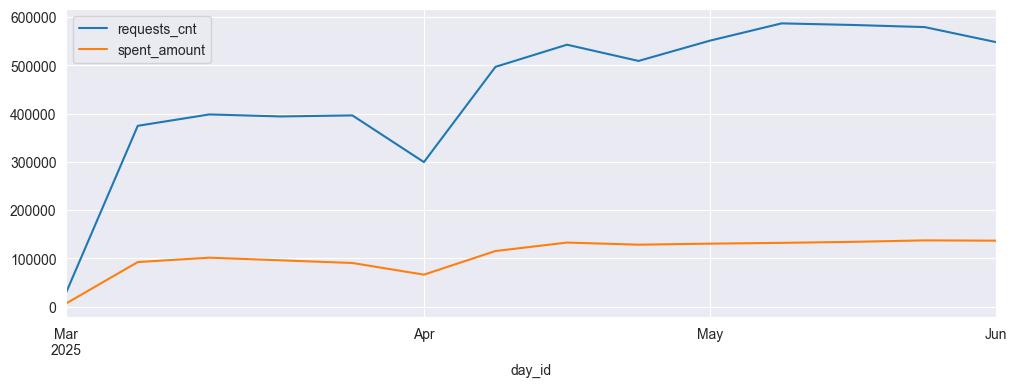

In [39]:
weekly = data.set_index('day_id').resample('W')[['requests_cnt','spent_amount']].sum()
weekly.plot(figsize=(12,4))

The weekly perspective shows again that first month wasn't so good as next two. The breakdown in April is visible here. We can't notice any trends.

<Axes: xlabel='day_id'>

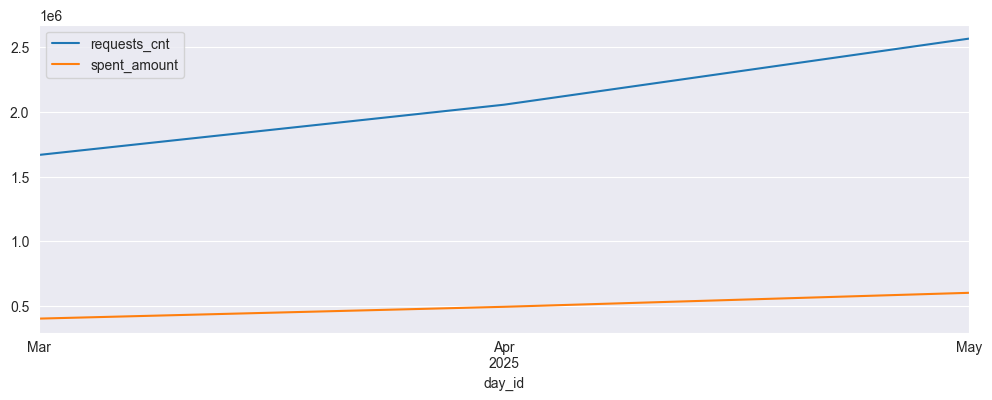

In [41]:
monthly = data.set_index('day_id').resample('ME')[['requests_cnt','spent_amount']].sum()
monthly.plot(figsize=(12,4))

In monthly perspective we see that users' activity increase linearly over time. It is good perspective for further development of LLM tools.

## Summary

Both requests_cnt and spent_amount are right-skewed, meaning most users use the tools moderately. The correlation between them is very high, so users who send more requests also spend more.

Basic and Standard licenses are most common, while Premium and Enterprise users show much higher activity. However, the variance is large, so differences should be interpreted cautiously.

Model_A is the most used, while Models C, D, and E tend to have higher request counts, likely linked to advanced license types. Feature_1–3 are most popular; Feature_4–5 are used less.

Time-based trends show increasing activity over the months, with regular drops probably on weekends and one drop in April. Overall usage is growing over time.